# Продажа квартир в Санкт-Петербурге — анализ рынка недвижимости

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
data = pd.read_csv('/datasets/real_estate_data.csv',sep='\t')
pd.set_option('display.max_columns', None)
data.head()# познакомимся с данными


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,False,False,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,False,False,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,False,False,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,False,False,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


In [2]:
data.info()#посмотрим информацию о данных детальнее

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

Итак, мы видим общее количество строк 23699, есть пропущенные значание в столбцах ceiling_height,floors_total,living_area , is_apartment, kitchen_area, balcony ,locality_name,  irports_nearest, cityCenters_nearest, parks_around3000, parks_around3000 ,parks_nearest ,ponds_around3000, ponds_nearest     days_exposition.

Tакже в некоторых столбцах некорректный тип данных, а именно:
- first_day_exposition тип object, необходимо поменять на datetime
- floors_total - тип float64, следует поменять на int
- is_apartment - object, надо поменять на bool 




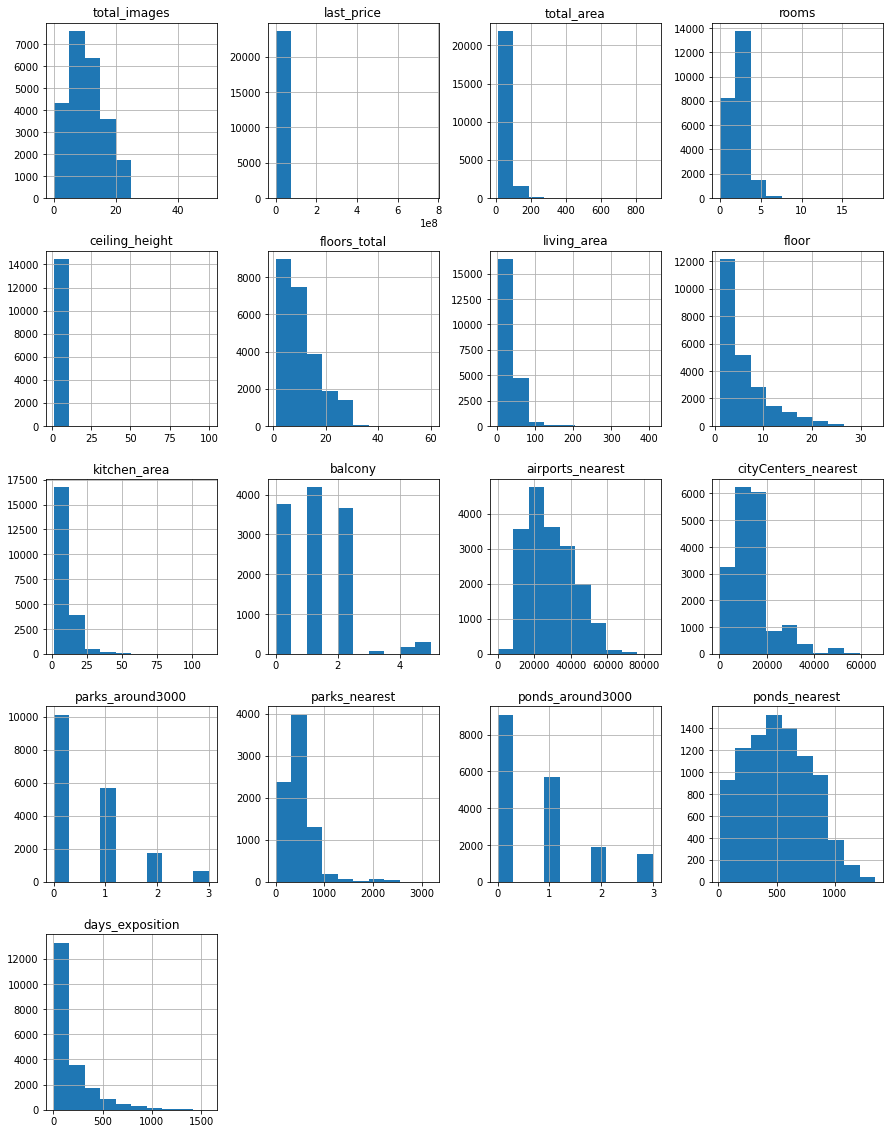

In [3]:
#  Построим общую гистограмму для всех столбцов таблицы
data.hist(figsize=(15,20));

Окинув взглядом, можно сделать вывод -  данные соответствуют здравому смыслу. Совсем не информативное представление по цене и высоте потолков. Будем разбираться подробнее.


### Предобработка данных

In [4]:
# Определим в каких столбцах есть пропуски
print(data.isna().sum())

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64


Начнем работу с каждым столбцом по порядку

In [5]:
# Поменяем тип тданных в стобце  first_day_exposition
#переведем столбец с датой в формат даты без времени,так как время не указано
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')
print(data['first_day_exposition'])

0       2019-03-07
1       2018-12-04
2       2015-08-20
3       2015-07-24
4       2018-06-19
           ...    
23694   2017-03-21
23695   2018-01-15
23696   2018-02-11
23697   2017-03-28
23698   2017-07-21
Name: first_day_exposition, Length: 23699, dtype: datetime64[ns]


In [6]:
# Разберемся с пропусками в столбце с высотой потолков
print('Количество пропусков =', data['ceiling_height'].isna().sum())

Количество пропусков = 9195


Внушительное количество пропусков 39%. Это может быть связано с тем, что продавцы квартир часто пропускают заполнение  этой строки, потому что не считают её существенной. Заполнить пропуски средним или медианным значением будет не корректно, так как высота потолков в центре Петербурга очевидно выше чем на окраине или в области. Можно кончено отследить зависимость высоты потолков от удаленности от центра и тогда вставить среднее значение в зависимости от этой категории, но не будем пока тратить на это время в рамках этого анализа.

In [7]:
# Посмотрим на список уникальных значений ceiling_height
data.groupby('ceiling_height').count().sort_values(by='ceiling_height',ascending=False)

,total_images,last_price,total_area,first_day_exposition,rooms,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
ceiling_height,,,,,,,,,,,,,,,,,,,,,
100.00,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
32.00,2,2,2,2,2,2,2,2,1,2,2,2,1,2,1,1,1,0,1,1,0
27.50,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1
27.00,8,8,8,8,8,8,8,8,4,8,8,6,7,8,3,3,3,0,3,2,7
26.00,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.20,1,1,1,1,1,1,1,1,0,1,1,1,1,1,0,0,0,0,0,0,1
2.00,11,11,11,11,11,11,9,11,1,11,11,9,4,11,3,3,3,2,3,2,8
1.75,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,0,1,1,1


Видим несколько аномальных значений как высоких так и низких потолков, потолки в 1м, 1,2м и 100 м скорее всего опечатка и встречается один раз, можно удалить эти строки. Высота 32,27,26 скорее всего не там проставлена точка по ошибке и надо будет разделить на 10.

Приступим

In [8]:
data = data.query('ceiling_height not in [1,1.2,1.75,100]')#удалим строки с аномальной высотой
data.groupby('ceiling_height').count().sort_values(by='ceiling_height',ascending=False)


,total_images,last_price,total_area,first_day_exposition,rooms,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
ceiling_height,,,,,,,,,,,,,,,,,,,,,
32.00,2,2,2,2,2,2,2,2,1,2,2,2,1,2,1,1,1,0,1,1,0
27.50,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1
27.00,8,8,8,8,8,8,8,8,4,8,8,6,7,8,3,3,3,0,3,2,7
26.00,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1
25.00,7,7,7,7,7,7,7,7,4,7,7,5,4,7,4,4,4,3,4,2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.34,1,1,1,1,1,1,0,1,0,1,1,0,0,1,0,0,0,0,0,0,1
2.30,4,4,4,4,4,4,4,4,2,4,4,4,4,4,1,1,1,1,1,1,4
2.25,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1


In [9]:
# Заменим значение высоты потолков,
#где неправильно указано дробное число, разделив эти строки на 10
data['ceiling_height'] = np.where(data['ceiling_height']<20,data['ceiling_height'], data['ceiling_height']/10)
data.groupby('ceiling_height').count().sort_values(by='ceiling_height',ascending=False)
                                                   


,total_images,last_price,total_area,first_day_exposition,rooms,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
ceiling_height,,,,,,,,,,,,,,,,,,,,,
14.00,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,0,1
10.30,1,1,1,1,1,1,1,1,0,1,1,0,0,1,1,1,1,1,1,1,1
8.30,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1
8.00,3,3,3,3,3,3,3,3,1,3,3,2,1,3,2,2,2,1,2,0,3
6.00,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2.30,4,4,4,4,4,4,4,4,2,4,4,4,4,4,1,1,1,1,1,1,4
2.26,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,0,1,0,1
2.25,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1


In [10]:
# Посмотрим на распределение значений
data['ceiling_height'].describe()

count    14500.000000
mean         2.729399
std          0.313453
min          2.000000
25%          2.510000
50%          2.650000
75%          2.800000
max         14.000000
Name: ceiling_height, dtype: float64

Заменим пропуски в столбце "высота потолков" медианным значением, среднее не подойдет, так как у нас все же остались выбивающиеся высокие  значения.

In [11]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

In [12]:
#Проверим остались ли пропуски
data['ceiling_height'].isna().sum()

0

Итак, мы удалили аномальные значения и заполнили пропуски медианным значением по высоте потолков.

In [13]:
#  Поменяем тип данных в столбце floors_total и заменим пропущенные значения
data['floors_total'] = data['floors_total'].fillna(1).astype(int)


Пропущенных значений в столбце меньше одного процента,  что не существенно, возможно это частные дома заменим на 1.

Столбец living_area,kitchen_area. Пропуски 8 %, но основным показателем является общая площадь, а жилая площадь и площадь кухни часто может быть быть не выделена если это студия или открытая планировка.

Столбец is_apartment выделяется по количеству пропусков - 88 %. Можно предположить что этот функционал добавили позже и не все пользователи его заполняли. Также на рынке недвижимости апартаменты сами по себе занимают меньшую долю в структуре других объектов и владельцы просто не заполняли эту информацию. Заменим пропущенные значения на False и изменим тип данных на bool

In [14]:
data['is_apartment'] = data['is_apartment'].fillna(False).astype(bool)

Столбец balcony. Также большее количество пропусков 48 %. Возможно балконов нет и владелец не указывает эту информацию совсем, либо не считает ее существенной отображая все на фотографиях.
Чтобы привести данные в порядок заменим пропуски нулями и поменяем тип данных на int

In [15]:
data['balcony'] = data['balcony'].fillna(0).astype(int)

Столбец locality_name пропусков 0,2% будем считать не существеным и удалим, потому что отсутствие данных в названии будем мешать нам в анализе данных при пригруппировке. 

In [16]:
data.dropna(subset=['locality_name'], inplace=True)

In [17]:
# Посмотрим уникальные значения в столбце
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Итак, можно заметить что присутствует разное написание поселок, посёлое, поселок городского типа, городской поселок. Заменим все эти различные варианты на "поселок".

In [18]:
data['locality_name'] = data['locality_name'].str.replace('посёлок','поселок')

In [19]:
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа','поселок')

In [20]:
data['locality_name'] = data['locality_name'].str.replace('городской поселок','поселок')

In [21]:
data['locality_name'] = data['locality_name'].str.replace('посёлок городского типа','поселок')

In [22]:
#Проверим
data['locality_name'].unique()

array(['Санкт-Петербург', 'поселок Шушары', 'поселок Янино-1',
       'поселок Парголово', 'поселок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок Красный Бор', 'Гатчина', 'деревня Фёдоровское', 'Выборг',
       'Кронштадт', 'Кировск', 'деревня Новое Девяткино',
       'поселок Металлострой', 'поселок Лебяжье', 'поселок Сиверский',
       'поселок Молодцово', 'поселок Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'поселок Аннино',
       'поселок Ефимовский', 'поселок Плодовое', 'деревня Заклинье',
       'поселок Торковичи', 'поселок Первомайское', 'Красное Село',
       'поселок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', 'поселок Новый Свет', 'Сланцы',
       'село Путилово', 'Ивангород', 'Мурино', 'Шлиссельбург',
       'Никольское', 'Зелено

Замена прошла удачно.

Стоблцы 	airports_nearest, cityCenters_nearest, parks_around3000,ponds_around3000 подозрительно похожее количество пропусков 5518-5519, а также столбцы parks_nearest и ponds_nearest около 15000 пропусков. Вероятно изначально были добавлены одни функиональные строки, а позже доработали другие. Или если мы имеем дело с  базой, где изначально была возможность заполнять все параметры, тогда вероятно картографические параметры не всегда корректно попадают в базу. Может быть они подтягиваются только тогда, когла у пользвателя включено определение геопозиции. В любом случае стоит поинтересоваться у коллег и уточнить этот вовпрос.
Поскольку все эти параметры не являются определяющими для стоимости недвижимости оставим данные как есть.

Столбец days_exposition. Проппущенных значений примерно 13%, параметр важный, но и заменить средним или медианной не имеет смысла, так как параметр очень индивидуальный. Оставим как есть. 

In [23]:
data.groupby('total_area').count().sort_values(by='total_area',ascending=False)

,total_images,last_price,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
total_area,,,,,,,,,,,,,,,,,,,,,
900.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1
631.2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0
631.0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,0,1,1,0
618.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1
590.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15.0,2,2,2,2,2,2,0,2,2,2,2,0,2,2,1,1,1,0,1,1,2
14.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1
13.2,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1


In [24]:
data['total_area'].describe()

count    23646.00000
mean        60.33239
std         35.66364
min         12.00000
25%         40.00000
50%         52.00000
75%         69.70750
max        900.00000
Name: total_area, dtype: float64

Видим выдающиеся знаяения у объктов с площадью 900,600,631.2,631,618. Эти значения могут мешать нам в дальнейшем анализе и поскольку это единичные объекты, стоит от них избавиться.

In [25]:
data = data.query('total_area<600.0')#удалим строки с аномальной площадью
data.groupby('total_area').count().sort_values(by='total_area',ascending=False)

,total_images,last_price,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
total_area,,,,,,,,,,,,,,,,,,,,,
590.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
517.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
507.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1
500.0,2,2,2,2,2,2,0,2,2,2,2,1,2,2,2,2,2,1,2,2,2
495.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15.0,2,2,2,2,2,2,0,2,2,2,2,0,2,2,1,1,1,0,1,1,2
14.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1
13.2,1,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,1,1,1,1


In [26]:
# Для удобства восприятия разделим столбец last_price на 100000
data['last_price'] = data['last_price']/1000000 
data.groupby('last_price').count().sort_values(by='last_price',ascending=False)

,total_images,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
last_price,,,,,,,,,,,,,,,,,,,,,
763.00000,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
401.30000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
330.00000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
289.23840,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
245.00000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.47000,3,3,3,3,3,3,2,3,3,3,3,2,3,3,0,0,0,0,0,0,3
0.45000,4,4,4,4,4,4,3,4,4,4,4,3,4,4,0,0,0,0,0,0,4
0.44000,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0,0,0,0,0,0,1


In [27]:
data['last_price'].describe()

count    23642.000000
mean         6.499918
std         10.314314
min          0.012190
25%          3.400000
50%          4.650000
75%          6.790000
max        763.000000
Name: last_price, dtype: float64

Заметны аномальные значения с высокой стоимостью в несколько сотен миллионов рублей, эти данные могут сильно влиять на среднюю стоимость, и поскольку это единочно встречающиеся объекты удалим строки, где стоимость выше 200 млн. рублей.

In [28]:
data = data.query('last_price<200.0')#удалим строки с аномальной стоимостью
data.groupby('last_price').count().sort_values(by='last_price',ascending=False)

,total_images,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
last_price,,,,,,,,,,,,,,,,,,,,,
190.87000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1
180.00000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
160.00000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
159.98400,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
159.00000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.47000,3,3,3,3,3,3,2,3,3,3,3,2,3,3,0,0,0,0,0,0,3
0.45000,4,4,4,4,4,4,3,4,4,4,4,3,4,4,0,0,0,0,0,0,4
0.44000,1,1,1,1,1,1,0,1,1,1,1,0,1,1,0,0,0,0,0,0,1


In [29]:
data.groupby('rooms').count().sort_values(by='rooms',ascending=False)

,total_images,last_price,total_area,first_day_exposition,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
rooms,,,,,,,,,,,,,,,,,,,,,
19,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1
16,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
15,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1
14,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2
11,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,1,1
10,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2,2
9,8,8,8,8,8,8,7,8,8,8,8,7,8,8,8,8,8,8,8,2,4
8,12,12,12,12,12,12,12,12,12,12,12,9,12,12,12,12,12,11,12,8,11
7,55,55,55,55,55,55,50,55,55,55,55,49,55,55,52,53,53,37,53,34,35


Видим несколько выделяющихся значений с количеством комнат больше 10. Для дальнейшего анализа оставим строки c количеством комнат до 10 включительно.

In [30]:
data = data.query('rooms<=10')#удалим строки с аномальной стоимостью
data.groupby('rooms').count().sort_values(by='rooms',ascending=False)

,total_images,last_price,total_area,first_day_exposition,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
rooms,,,,,,,,,,,,,,,,,,,,,
10,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2,2
9,8,8,8,8,8,8,7,8,8,8,8,7,8,8,8,8,8,8,8,2,4
8,12,12,12,12,12,12,12,12,12,12,12,9,12,12,12,12,12,11,12,8,11
7,55,55,55,55,55,55,50,55,55,55,55,49,55,55,52,53,53,37,53,34,35
6,102,102,102,102,102,102,97,102,102,102,102,94,102,102,99,99,99,67,99,70,73
5,325,325,325,325,325,325,291,325,325,325,325,284,325,325,299,300,300,194,300,192,251
4,1175,1175,1175,1175,1175,1175,1084,1175,1175,1175,1175,1076,1175,1175,1051,1053,1053,560,1053,621,936
3,5796,5796,5796,5796,5796,5796,5350,5796,5796,5796,5796,5365,5796,5796,4680,4684,4685,2199,4685,2389,4802
2,7921,7921,7921,7921,7921,7921,7279,7921,7921,7921,7921,7270,7921,7921,5901,5911,5911,2669,5911,2840,6895


In [31]:
data.shape[0]

23628

Изначально количество строк было 23699. Мы сократили исходные данные меньше чем на 1%.

### Посчитайте и добавьте в таблицу новые столбцы

In [32]:
#посчитаем цену одного квадратного метра
data['one_meter_price'] = data['last_price'] / data['total_area']

In [33]:
# Добавляем столбцы дня недели, месяца и года
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday
data['month_exposition'] = data['first_day_exposition'].dt.month
data['year_exposition'] = data['first_day_exposition'].dt.year

In [34]:
#Добавим столбец с типом этажа квартиры
#с помощью функции
def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
data['floor_type'] = data.apply(floor_type, axis=1)


In [35]:
#Добавим столбец расстояние до центра города в км
data['cityCenters_km'] = data['cityCenters_nearest']/1000
data['cityCenters_km'] = data['cityCenters_km'].round(0)

In [36]:
# Посмотрим полученные столбцы
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,one_meter_price,weekday_exposition,month_exposition,year_exposition,floor_type,cityCenters_km
0,20,13.000,108.00,2019-03-07,3,2.70,16,51.00,8,False,False,False,25.00,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,0.120370,3,3,2019,другой,16.0
1,7,3.350,40.40,2018-12-04,1,2.65,11,18.60,1,False,False,False,11.00,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,0.082921,1,12,2018,первый,19.0
2,10,5.196,56.00,2015-08-20,2,2.65,5,34.30,4,False,False,False,8.30,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,0.092786,3,8,2015,другой,14.0
3,0,64.900,159.00,2015-07-24,3,2.65,14,NaN,9,False,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,0.408176,4,7,2015,другой,7.0
4,2,10.000,100.00,2018-06-19,2,3.03,14,32.00,13,False,False,False,41.00,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,0.100000,1,6,2018,другой,8.0
5,10,2.890,30.40,2018-09-10,1,2.65,12,14.40,5,False,False,False,9.10,0,поселок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0,0.095066,0,9,2018,другой,NaN
6,6,3.700,37.30,2017-11-02,1,2.65,26,10.60,6,False,False,False,14.40,1,поселок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0,0.099196,3,11,2017,другой,19.0
7,5,7.915,71.60,2019-04-18,2,2.65,24,NaN,22,False,False,False,18.90,2,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN,0.110545,3,4,2019,другой,12.0
8,20,2.900,33.16,2018-05-23,1,2.65,27,15.43,26,False,False,False,8.81,0,поселок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0,0.087455,2,5,2018,другой,NaN
9,18,5.400,61.00,2017-02-26,3,2.50,9,43.60,7,False,False,False,6.50,2,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0,0.088525,6,2,2017,другой,15.0


### исследовательский анализ данных

count    23628.000000
mean        60.066213
std         33.924521
min         12.000000
25%         40.000000
50%         52.000000
75%         69.602500
max        517.000000
Name: total_area, dtype: float64

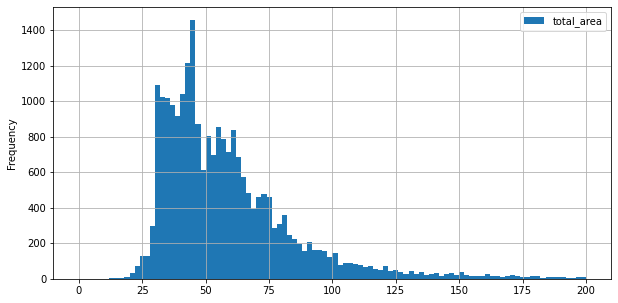

In [37]:
#изучим общую площадь
data.plot(y = 'total_area', kind = 'hist', bins = 100, grid=True, figsize = (10,5), range = (0,200));
data['total_area'].describe()

Средняя площадь объктов в продаже 60 кв.м. Большинство размещенных объявлений с площадью объектов до 50 кв.м.Есть также выдающаяся по площади недвижимсоть в 900 кв. м.,но в целом объект больше 150 кв.м уже редкость. Также представлены объекты площадью меньше 20 кв.м., но количество их не велико. 

count    21732.000000
mean        34.314110
std         21.307422
min          2.000000
25%         18.600000
50%         30.000000
75%         42.270000
max        347.500000
Name: living_area, dtype: float64

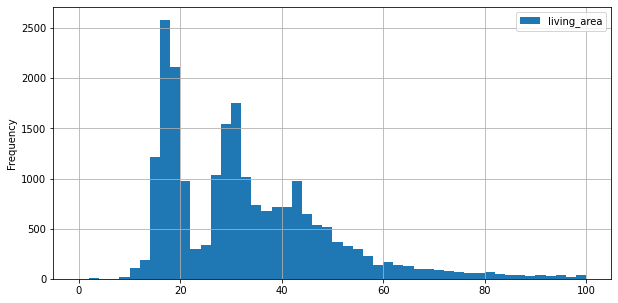

In [38]:
#изучим жилую площадь
data.plot(y = 'living_area', kind = 'hist', bins = 50, grid=True, figsize = (10,5), range = (0,100));
data['living_area'].describe()

 Средняя жилая площадь 34 кв.м.,но все же больщше всего объектов в продаже с жилой площадью менее 20 кв.м. Скорее всего это связано с большим количеством однакомнатных квартир,рассмотрим это дальше. Также наблюдается неравномерность в распределении данных, резкие впадины на гистограмме, возможно это связано с большим количеством пропусков данных в этом столбце.

count    21360.000000
mean        10.543629
std          5.790561
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        107.000000
Name: kitchen_area, dtype: float64

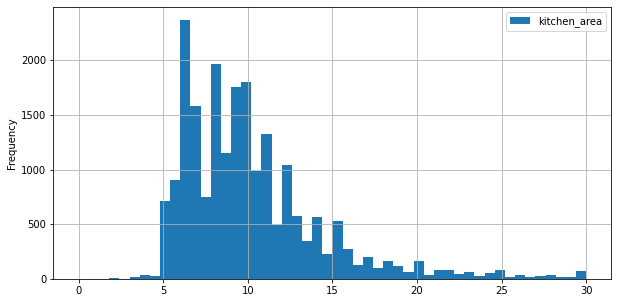

In [39]:
#изучим  площадь кухни
data.plot(y = 'kitchen_area', kind = 'hist', bins = 50, grid=True, figsize = (10,5), range = (0,30));
data['kitchen_area'].describe()

Средняя  площадь кухни 10 кв.м.,но все же больщше всего объектов в продаже с площадью кухни около 6 кв.м.

6.388293708142881

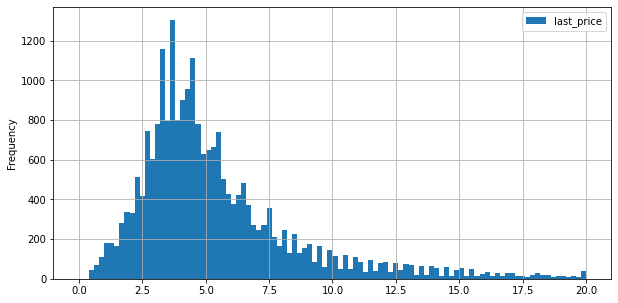

In [40]:
#изучим  стоимость объекта
data.plot(y = 'last_price', kind = 'hist', bins = 100, grid=True, figsize = (10,5), range = (0,20));
data['last_price'].mean()

Средняя стоимость объекта в продаже 6,4 миллионов рублей.  Объектов стоимостью от 12 млн значительно меньше.

count    23628.000000
mean         2.064669
std          1.052384
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         10.000000
Name: rooms, dtype: float64

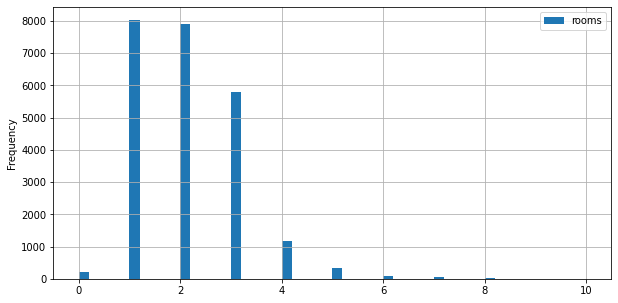

In [41]:
#изучим  количество комнат
data.plot(y = 'rooms', kind = 'hist', bins = 50, grid=True, figsize = (10,5), range = (0,10));
data['rooms'].describe()

Итак видим, что на рынке недвижимости лидируют однушки и двушки.

count    23628.000000
mean         2.698167
std          0.247805
min          2.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         14.000000
Name: ceiling_height, dtype: float64

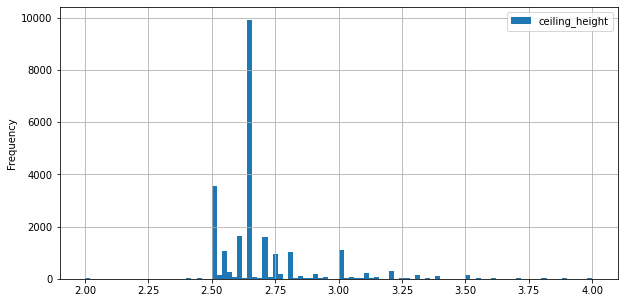

In [42]:
#изучим  высоту потолков
data.plot(y = 'ceiling_height', kind = 'hist', bins = 100, grid=True, figsize = (10,5), range = (2,4));
data['ceiling_height'].describe()

Средняя высота потолков 2,7 метров, больше всего в продаже объектов с высотой 2,6 м.

count    23628.000000
mean         5.893305
std          4.883456
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

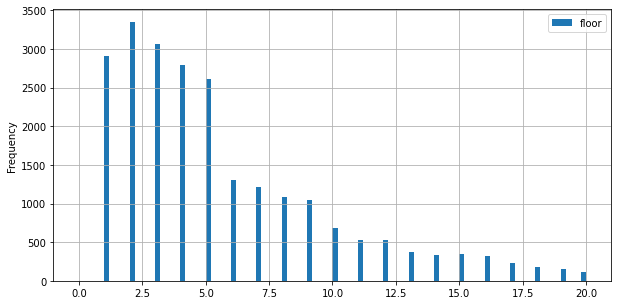

In [43]:
#изучим  этаж квартиры
data.plot(y = 'floor', kind = 'hist', bins = 100, grid=True, figsize = (10,5), range = (0,20));
data['floor'].describe()

Больше всего в продаже представленно объектов на 2 этаже.

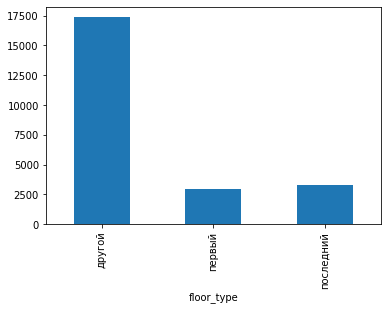

In [44]:
#изучим  распределение по типу этажа
data.groupby('floor_type')['last_price'].count().plot(kind = 'bar');


Как и показал предыдущий пункт лидирует тип "другой".

count    23628.000000
mean        10.643135
std          6.606989
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

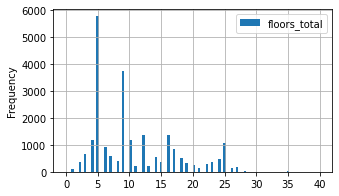

In [45]:
#изучим  общее количесвто этажей в доме
data.plot(y = 'floors_total', kind = 'hist', bins = 100, grid=True, figsize = (5,3), range = (0,40));
data['floors_total'].describe()

Средний образ объкта 10 этажный дом, объекты выше 30 этажей уже редкость, но все таки больше всего на рынке представленно пятиэтажек.

count    18118.000000
mean        14.201623
std          8.613292
min          0.000000
25%          9.000000
50%         13.000000
75%         16.000000
max         66.000000
Name: cityCenters_km, dtype: float64

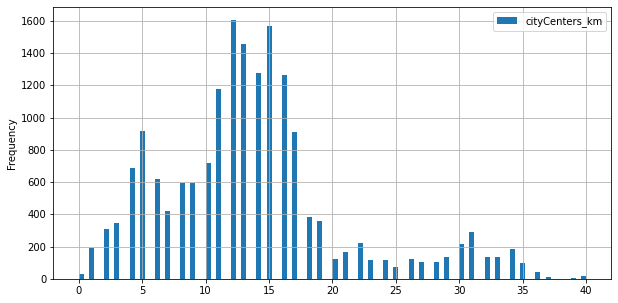

In [46]:
#изучим расстояние до центра города
data.plot(y = 'cityCenters_km', kind = 'hist', bins = 100, grid=True, figsize = (10,5), range = (0,40));
data['cityCenters_km'].describe()

Среднее расстояние до центра 15 км, объекты с расстоянием до центра свыше 20 км встречаются гораздо реже.

count    18095.000000
mean     28805.504836
std      12643.044995
min          0.000000
25%      18573.000000
50%      26757.000000
75%      37310.000000
max      84869.000000
Name: airports_nearest, dtype: float64

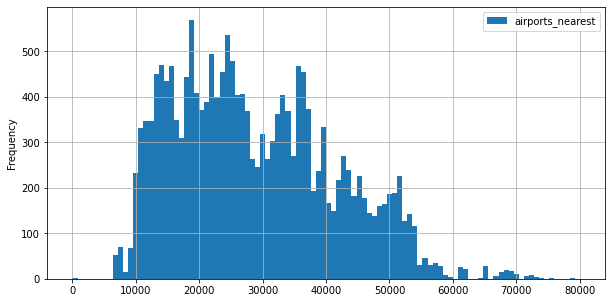

In [47]:
#изучим расстояние до ближайшего аэропорта
data.plot(y = 'airports_nearest', kind = 'hist', bins = 100, grid=True, figsize = (10,5), range = (0,80000));
data['airports_nearest'].describe()

Среднее расстояние до аэропорта у объектов в продаже 28 км, оснавная масса объектов с расстоянием до 40 км.

count    8053.000000
mean      490.829877
std       342.742478
min         1.000000
25%       287.000000
50%       454.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

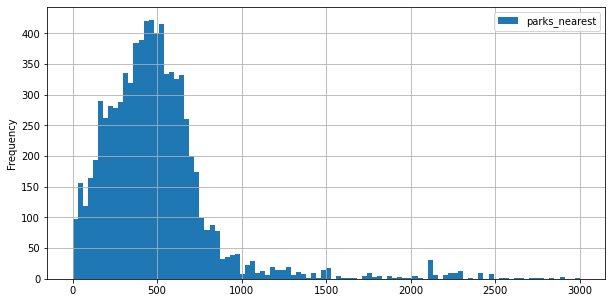

In [48]:
#изучим расстояние до ближайшего парка
data.plot(y = 'parks_nearest', kind = 'hist', bins = 100, grid=True, figsize = (10,5), range = (0,3000));
data['parks_nearest'].describe()

Среднее расстояние до ближайшего парка у объектов в продаже около 500 м, оснавная масса объектов с расстоянием до 700 м. 

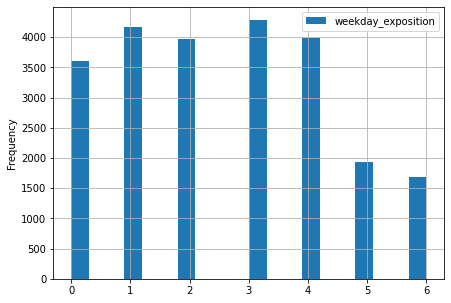

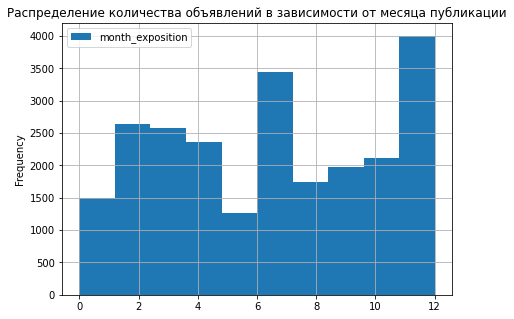

count    23628.000000
mean         6.401938
std          3.491471
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month_exposition, dtype: float64

In [49]:
#изучим день и месяц публикации
data.plot(y = 'weekday_exposition', kind = 'hist', bins = 20, grid=True, figsize = (7,5), range = (0,6));
data.plot(y = 'month_exposition', kind = 'hist', bins = 10, grid=True, figsize = (7,5), range = (0,12));
plt.title('Распределение количества объявлений в зависимости от месяца публикации') 
plt.show()
data['month_exposition'].describe()

Можно заметить, что чаще всего объявления размещают во вторник и четверг, а реже всего в выходные. Что касается месяца размещения - лидирует декабрь, наверное многие хотят начать  новую жизнь с января)

count    20452.000000
mean       180.690104
std        219.644190
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

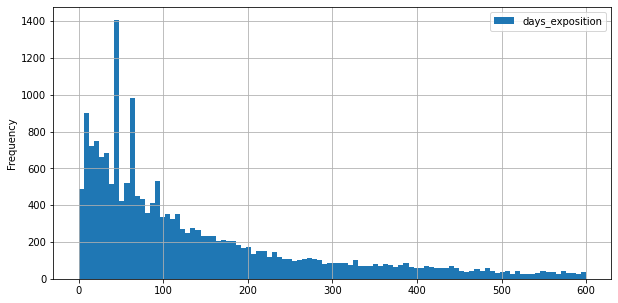

In [50]:
#Изучим как быстро продавались квартиры
data.plot(y='days_exposition', kind='hist', bins=100, grid=True, figsize=(10,5), range=(0,600));
data['days_exposition'].describe()

Средняя продолжительность размещения объявления 180 дней, но чаще квартиры продавались в диапазоне до 50 дней, что соответсвует здравому смыслу. Кроме того есть объекты,которые зависли и не продаются больше года, но их гораздо меньше. Самое длительное размещение больше 4 лет. Необычно быстрые продажи также присутствуют и составляют 1 день.

 **Изучим какие факторы больше всего влияют на общую стоимость объекта**

In [51]:
data.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,one_meter_price,weekday_exposition,month_exposition,year_exposition,floor_type,cityCenters_km
0,20,13.000,108.0,2019-03-07,3,2.70,16,51.0,8,False,False,False,25.0,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN,0.120370,3,3,2019,другой,16.0
1,7,3.350,40.4,2018-12-04,1,2.65,11,18.6,1,False,False,False,11.0,2,поселок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,0.082921,1,12,2018,первый,19.0
2,10,5.196,56.0,2015-08-20,2,2.65,5,34.3,4,False,False,False,8.3,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,0.092786,3,8,2015,другой,14.0
3,0,64.900,159.0,2015-07-24,3,2.65,14,NaN,9,False,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,0.408176,4,7,2015,другой,7.0
4,2,10.000,100.0,2018-06-19,2,3.03,14,32.0,13,False,False,False,41.0,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,0.100000,1,6,2018,другой,8.0


In [52]:
t = (data.loc[:, ['total_area', 'living_area','kitchen_area','rooms',
                  'floor_type','weekday_exposition','month_exposition',
                  'year_exposition','last_price']])
t.head()

,total_area,living_area,kitchen_area,rooms,floor_type,weekday_exposition,month_exposition,year_exposition,last_price
0,108.0,51.0,25.0,3,другой,3,3,2019,13.000
1,40.4,18.6,11.0,1,первый,1,12,2018,3.350
2,56.0,34.3,8.3,2,другой,3,8,2015,5.196
3,159.0,NaN,NaN,3,другой,4,7,2015,64.900
4,100.0,32.0,41.0,2,другой,1,6,2018,10.000


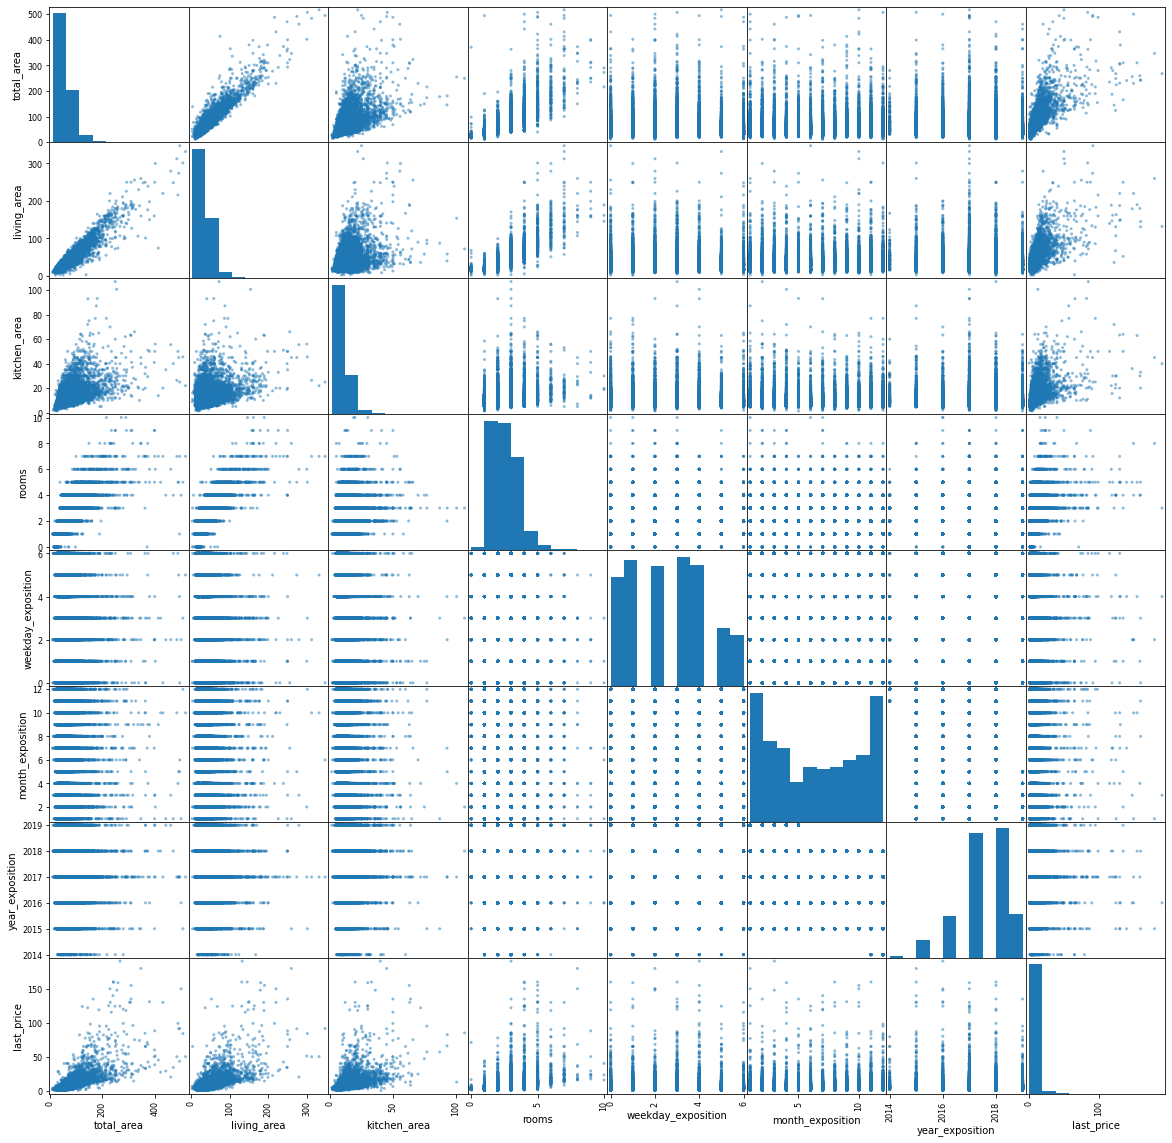

In [53]:
#Построим матрицу рассеивания
pd.plotting.scatter_matrix(t, figsize=(20, 20)); 

Наглядность не очень презентабельна, разве что можно рассмотреть зависимоть от площади.

In [54]:
# Вычислим коэффициенты корреляции
t.corr().tail(1)

,total_area,living_area,kitchen_area,rooms,weekday_exposition,month_exposition,year_exposition,last_price
last_price,0.733754,0.655256,0.562772,0.433138,-0.001455,0.004168,-0.058974,1.0


In [55]:
(data.loc[:,['total_area', 'living_area',
             'kitchen_area','rooms','last_price']].corr().tail(1))

,total_area,living_area,kitchen_area,rooms,last_price
last_price,0.733754,0.655256,0.562772,0.433138,1.0


Больше всего показатель корреляции стоимости и  общей площади объекта, что соответствует здравому смыслу. 


Рассмотрим подробнее зависимость стоимости и года размещения. Посмотрим что происходило с ценами на рынке недвижимости в заданном диапазоне времени.

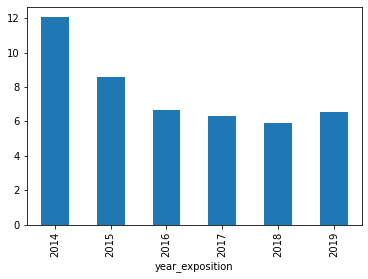

In [56]:
data.groupby('year_exposition')['last_price'].mean().plot(kind='bar');

Видим,что  цены просели в 2015-2018 гг, и начали восстанавливаться в 2019г.

Категориальный столбец с типом этажа не отобразился в корреляции,рассмотрим отдельно.

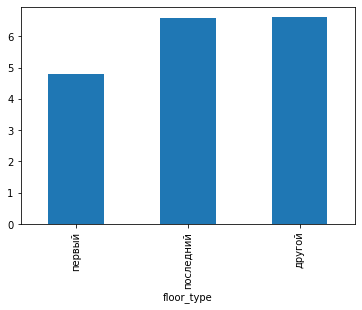

In [57]:
data.groupby('floor_type')['last_price'].mean().sort_values().plot(kind='bar');

In [58]:
print(data.groupby('floor_type')['last_price'].mean())

floor_type
другой       6.618218
первый       4.801598
последний    6.574688
Name: last_price, dtype: float64


Средняя стоимость объекта на первом этаже ниже стоимости на других этажах на 27%, очень  существенно. 

Небольшой процент корреляции между количеством комнат и стомостью квартиры, рассмотрим  подробнее.

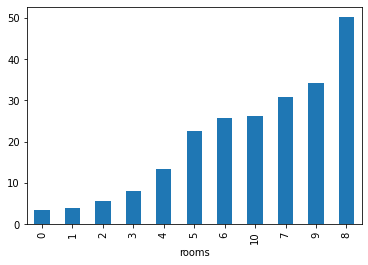

In [59]:
data.groupby('rooms')['last_price'].mean().sort_values().plot(kind='bar');

Чем больше комнат, тем выше стоимость, ну что и логично, площадь тогда тоже больше. Но этот параметр не показателен, гораздо корректнее тогда смотреть на стоимость одного квадратного метра.

 **Посчитаем среднюю цену одного квадратного метра в 10 населенных пунктах с наибольшим числом объвлений**.

In [60]:
#Сгрупируем данные по наименованию населеного пункта и выведем первые 10 строк с наибольшим количеством обявлений
group_locality = data.groupby('locality_name')['one_meter_price'].count().sort_values(ascending=False)
print(group_locality.head(10))

locality_name
Санкт-Петербург      15700
поселок Мурино         556
поселок Шушары         440
Всеволожск             398
Пушкин                 369
Колпино                338
поселок Парголово      327
Гатчина                307
деревня Кудрово        299
Выборг                 237
Name: one_meter_price, dtype: int64


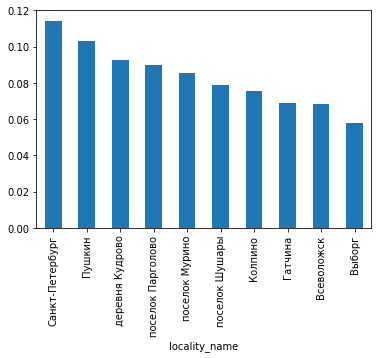

In [61]:
# Сформируем срез из 10 населенных пунктов и сохраним в новую переменную
group_locality_ten = data.query('locality_name in ["Санкт-Петербург","поселок Мурино","поселок Шушары","Всеволожск","Пушкин","Колпино","поселок Парголово","поселок Парголово","Гатчина","деревня Кудрово","Выборг"]')
#Построим график 
group_locality_ten.groupby('locality_name')['one_meter_price'].mean().sort_values(ascending=False).plot(kind='bar');

In [62]:
group_locality_ten.groupby('locality_name')['one_meter_price'].mean().sort_values(ascending=False)

locality_name
Санкт-Петербург      0.114299
Пушкин               0.103126
деревня Кудрово      0.092474
поселок Парголово    0.090176
поселок Мурино       0.085682
поселок Шушары       0.078677
Колпино              0.075425
Гатчина              0.068746
Всеволожск           0.068654
Выборг               0.058142
Name: one_meter_price, dtype: float64

Итак, мы видим, что самая высокaя цена за квадратный метр в Санкт-Петербурге, в тройке лидеров также Пушкин и деревня Кудрово. Самая низкая цена из 10 наиболее представленных на рынке недвижимости населеных пунктов в Выборге.

**Выделим среднию цену каждого киллометра в Санкт_Петербурге.**

In [63]:
#Возьмем срез данных только по Санкт-Петербургу
group_spb = data.query('locality_name in ["Санкт-Петербург"]')

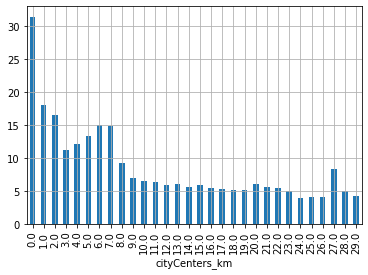

In [64]:
#Сгруппируем объекты по удаленности от центра
group_spb.groupby('cityCenters_km')['last_price'].mean().plot(kind='bar',grid=True);

Можно заметить, что в самом центре средняя стоимость объекта составляет порядка 30 миллионов рублей. На расстоянии от центра в 1 км стоимость падает уже до 18 миллионов и далее не совсем равномерно, но продолжает снижаться. И объекты на удаленности от 10-20 км стоят уже в районе 5-6 миллионов рублей.

### Общий вывод

В ходе исследование были обнаруженны пропуски в данных, больше всего пропусков в параметрах, полученных на основе картографических данных.

Была проведенна предообработка данных, заменены дубликаты в названиях населенных пунктов, изменен тип данных в некоторых столбцах, удуалены аномальные значения.

В ходе исследования данных были обнаруженны следующие тенденции.

Средняя площадь объктов в продаже 60 кв.м. Большинство размещенных объявлений с площадью объектов до 50 кв.м.

Средняя стоимость объекта в продаже 6,4 миллионов рублей. Объектов стоимостью от 12 млн значительно меньше.

На рынке недвижимости Петербурга лидируют однушки и двушки.

Средний образ объкта 10 этажный дом, объекты выше 30 этажей уже редкость, но все таки больше всего на рынке представленно пятиэтажек.

Больше всего представлено объектов со средним расстояние до центра 15 км, объекты с расстоянием до центра свыше 20 км встречаются гораздо реже.

Среднее расстояние до аэропорта у объектов в продаже -  28 км.
Среднее расстояние до ближайшего парка у объектов в продаже - около 500 м.

Было выявленно, что чаще всего объявления размещают во вторник и четверг, а реже всего в выходные. Что касается месяца размещения -  лидирует декабрь.

Средняя продолжительность размещения объявления 180 дней, но чаще квартиры продавались в диапазоне до 50 дней.

На основании анализа данных обнаружена наибольшая  корреляция стоимости объекта и его площади.

В ходе исследование выявленно снижение цен на недвижимость в Санкт-Петербурге в 2015-2018 гг.

Cамая высокaя средняя цена за один квадратный метр наблюдается в Санкт-Петербурге и составляет 114299 рублей, в тройке лидеров также Пушкин и деревня Кудрово, там цены ниже примерно на 10 и 20 процентов соответственно. Самая низкая цена из 10 наиболее представленных на рынке недвижимости населеных пунктов в Выборге(58142 рублей).

Что касается удаленности от центра, то в самом центре средняя стоимость объекта составляет порядка 30 миллионов рублей. На расстоянии от центра в 1 км стоимость падает уже на 40% до 18 миллионов и далее не совсем равномерно, но продолжает снижаться, объекты на удаленности от 10-20 км стоят уже в районе 5-6 миллионов рублей.
